In [19]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import graph
from graph import *
from node import *
from part import *

# Suppose you have your own classes:
# Graph, Node, Part
# For illustration, here are minimal stubs:

############################################################
# 1) Prepare sample graphs
############################################################
with open('./data/graphs.dat', 'rb') as file:
    train_graphs_list: List[Graph] = pickle.load(file)
    train_graphs_list = train_graphs_list[:20]


############################################################
# 2) Build a PyTorch Dataset
############################################################
class LinkPredictionDataset(Dataset):

    """
    Creates positive/negative samples from each Graph.
    For each Graph:
      - Collect all nodes
      - For every pair (i, j), check if it's an edge (label=1) or not (label=0)
    """
    def __init__(self, graphs: List[Graph]):
        super().__init__()
        self.samples = []

        for g in graphs:
            # Get the nodes and edges
            node_list = g.get_nodes()          # List[Node]
            edge_list = g.get_edges()          # List of (Node, Node)
            edge_set = self.get_edge_list(edge_list)        # for quick membership checks

            # Map node ID -> (part_id, family_id)
            node_id_to_features = {}
            for node in node_list:
                node_id_to_features[node.get_id()] = (
                    node.get_part().get_part_id(),
                    node.get_part().get_family_id()
                )

            # We'll gather all node IDs from the node list
            node_ids = [n.get_id() for n in node_list]
            id_to_node = {n.get_id(): n for n in node_list}

            # Create all (i, j) pairs
            for i in node_ids:
                for j in node_ids:
                    if i == j:
                        continue
                    part_i, fam_i = node_id_to_features[i]
                    part_j, fam_j = node_id_to_features[j]

                    # Sort the pair for an undirected edge check
                    pair = tuple(sorted([id_to_node[i], id_to_node[j]],
                                        key=lambda x: x.get_id()))
                    label = 1 if pair in edge_set else 0

                    self.samples.append((int(part_i), int(fam_i), int(part_j), int(fam_j), int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]  # (part_i, fam_i, part_j, fam_j, label)
    def get_edge_list(self, __edges: Dict[Node, List[Node]]):
        edge_pairs = set()  # use a set to avoid duplicates

        for src, neighbors in __edges.items():
            for dst in neighbors:
                # Sort the pair so that (NodeA, NodeB) == (NodeB, NodeA)
                sorted_pair = tuple(sorted([src, dst], key=lambda n: n.get_id()))
                edge_pairs.add(sorted_pair)

        return edge_pairs  # Now we have a list of (Node, Node) pairs


############################################################
# 3) Create the dataset & figure out vocab size
############################################################
all_part_ids = []
all_family_ids = []
for graph in train_graphs_list:
    for n in graph.get_nodes():
        all_part_ids.append(int(n.get_part().get_part_id()))
        all_family_ids.append(int(n.get_part().get_family_id()))

part_vocab_size = max(all_part_ids) + 1
family_vocab_size = max(all_family_ids) + 1

dataset = LinkPredictionDataset(train_graphs_list)
print("Number of training pairs:", len(dataset))

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


############################################################
# 4) Define a simple model for link prediction
############################################################
class EdgePredictor(nn.Module):
    def __init__(self, part_vocab_size, family_vocab_size,
                 embed_dim=16, hidden_dim=32):
        super().__init__()
        self.part_embedding = nn.Embedding(part_vocab_size, embed_dim)
        self.family_embedding = nn.Embedding(family_vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, part_i, fam_i, part_j, fam_j):
        """
        part_i, fam_i, part_j, fam_j are integer tensors
        of shape (batch_size,).
        """
        pi = self.part_embedding(part_i)  # (B, embed_dim)
        fi = self.family_embedding(fam_i) # (B, embed_dim)
        pj = self.part_embedding(part_j)  # (B, embed_dim)
        fj = self.family_embedding(fam_j) # (B, embed_dim)

        x = torch.cat([pi, fi, pj, fj], dim=1)  # (B, 4*embed_dim)
        x = self.relu(self.fc1(x))             # (B, hidden_dim)
        x = self.fc2(x)                        # (B, 1)
        return x.squeeze(1)  # (B,)


############################################################
# 5) Train the model
############################################################
model = EdgePredictor(part_vocab_size, family_vocab_size, embed_dim=16, hidden_dim=32)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 200  # For demo, keep it smaller
model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    for batch in dataloader:
        part_i, fam_i, part_j, fam_j, label = batch
        # Convert to Long / Float for embeddings + BCE
        part_i = part_i.long()
        fam_i  = fam_i.long()
        part_j = part_j.long()
        fam_j  = fam_j.long()
        label  = label.float()

        optimizer.zero_grad()
        logits = model(part_i, fam_i, part_j, fam_j)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


############################################################
# 6) Predict edges on NEW sets of (part_id, family_id)
############################################################


@torch.no_grad()
def predict_edges(model, parts: list[Part], threshold=0.5):
    """
    part_family_list: list of (part_id, family_id)
    We will return a list of edges (i, j) for i < j if predicted prob > threshold.
    """
    model.eval()
    n = len(parts)
    graph = Graph()

    for i in range(n):
        for j in range(i + 1, n):
            part_i, fam_i = int(parts[i].get_part_id()), int(parts[i].get_family_id())
            part_j, fam_j = int(parts[j].get_part_id()), int(parts[j].get_family_id())

            pi = torch.tensor([part_i], dtype=torch.long)
            fi = torch.tensor([fam_i], dtype=torch.long)
            pj = torch.tensor([part_j], dtype=torch.long)
            fj = torch.tensor([fam_j], dtype=torch.long)

            logit = model(pi, fi, pj, fj)
            prob = torch.sigmoid(logit)
            if prob.item() > threshold:
                graph.add_edge(parts[i], parts[j])
                graph.add_edge(parts[j], parts[i])

    return graph


# Example of new data:
test_parts = train_graphs_list[3].get_parts()

predicted = predict_edges(model, list(test_parts), threshold=0.5)
train_graphs_list[3].draw()
predicted.draw()



Number of training pairs: 980
Epoch 1/200 - Loss: 0.7034
Epoch 2/200 - Loss: 0.6308
Epoch 3/200 - Loss: 0.5837
Epoch 4/200 - Loss: 0.5367
Epoch 5/200 - Loss: 0.5093
Epoch 6/200 - Loss: 0.4861
Epoch 7/200 - Loss: 0.4578
Epoch 8/200 - Loss: 0.4352
Epoch 9/200 - Loss: 0.4151
Epoch 10/200 - Loss: 0.3948
Epoch 11/200 - Loss: 0.3797
Epoch 12/200 - Loss: 0.3663
Epoch 13/200 - Loss: 0.3426
Epoch 14/200 - Loss: 0.3227
Epoch 15/200 - Loss: 0.3158
Epoch 16/200 - Loss: 0.3064
Epoch 17/200 - Loss: 0.2869
Epoch 18/200 - Loss: 0.2840
Epoch 19/200 - Loss: 0.2667
Epoch 20/200 - Loss: 0.2511
Epoch 21/200 - Loss: 0.2523
Epoch 22/200 - Loss: 0.2415
Epoch 23/200 - Loss: 0.2281
Epoch 24/200 - Loss: 0.2299
Epoch 25/200 - Loss: 0.2154
Epoch 26/200 - Loss: 0.2118
Epoch 27/200 - Loss: 0.2053
Epoch 28/200 - Loss: 0.2009
Epoch 29/200 - Loss: 0.1940
Epoch 30/200 - Loss: 0.1943
Epoch 31/200 - Loss: 0.1834
Epoch 32/200 - Loss: 0.1761
Epoch 33/200 - Loss: 0.1712
Epoch 34/200 - Loss: 0.1655
Epoch 35/200 - Loss: 0.1662

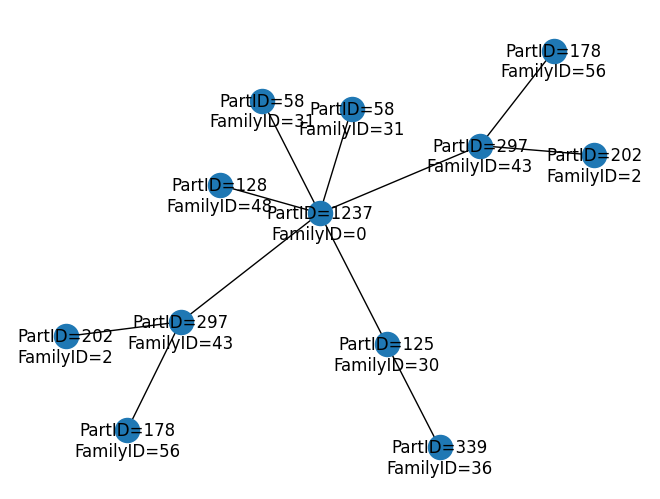

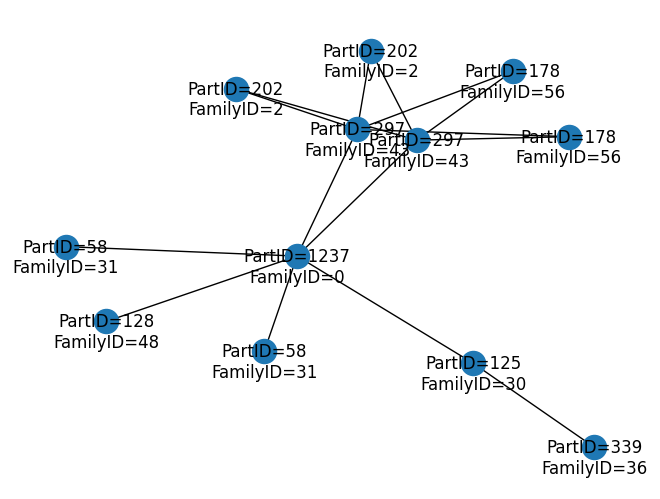

In [42]:
@torch.no_grad()
def predict_edges(model, parts: list[Part], threshold=0.5):
    """
    part_family_list: list of (part_id, family_id)
    We will return a list of edges (i, j) for i < j if predicted prob > threshold.
    """
    model.eval()
    n = len(parts)
    graph = Graph()

    for i in range(n):
        for j in range(i+1, n):
            part_i, fam_i = int(parts[i].get_part_id()), int(parts[i].get_family_id())
            part_j, fam_j = int(parts[j].get_part_id()), int(parts[j].get_family_id())

            pi = torch.tensor([part_i], dtype=torch.long)
            fi = torch.tensor([fam_i],  dtype=torch.long)
            pj = torch.tensor([part_j], dtype=torch.long)
            fj = torch.tensor([fam_j],  dtype=torch.long)

            logit = model(pi, fi, pj, fj)
            prob = torch.sigmoid(logit)
            if prob.item() > threshold:
                graph.add_edge(parts[i], parts[j])
                graph.add_edge(parts[j], parts[i])

    return graph

# Example of new data:
test_parts = train_graphs_list[3].get_parts()

predicted = predict_edges(model, list(test_parts), threshold=0.5)
train_graphs_list[3].draw()
predicted.draw()